# Regridding model data with xESMF

## Import python packages

In [97]:
# supress warnings
import warnings
warnings.filterwarnings('ignore') # don't output warnings

import os
# import packages
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import xesmf as xe
#from cmcrameri import cm
from pathlib import Path
%matplotlib inline

## Set path to save data:
Further down in this notebook, an intermediate data product is saved. It is often smart to put this in another directory than your code directory. Below we set the path where this is saved:

In [98]:
!pwd

/home/fc-3auid-3aeb54868a-2dc3bf-2d4cf2-2d9a1a-2d7ab42345078a/eScience2024/docs/learning/notebooks


You can copy the home path from above, or you can make a relative path. 

In [99]:
path_to_save_data = '../../../../Data_processed'

In [100]:
path_to_save_data = Path(path_to_save_data)

path_to_save_data.mkdir(exist_ok=True)

## Open CMIP6 online catalog

In [101]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


## Get data in xarray
### Search od550aer variable dataset

In [102]:
cat = col.search(experiment_id=['historical'], variable_id='od550aer', member_id=['r1i1p1f1'], grid_label='gn')
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2-WACCM,historical,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,20190227
1,CMIP,NCAR,CESM2,historical,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
2,CMIP,CCCma,CanESM5,historical,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
3,CMIP,HAMMOZ-Consortium,MPI-ESM-1-2-HAM,historical,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ES...,NaN,20190627
4,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...,NaN,20190710
5,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/hist...,NaN,20190710
6,CMIP,NCC,NorESM2-LM,historical,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/CMIP6/CMIP/NCC/NorESM2-LM/historica...,NaN,20190815
7,CMIP,BCC,BCC-ESM1,historical,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/historical/...,NaN,20190918
8,CMIP,NCAR,CESM2-WACCM-FV2,historical,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM-FV2/his...,NaN,20191120
9,CMIP,NCAR,CESM2-FV2,historical,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-FV2/historica...,NaN,20191120


In [103]:
cat.df['source_id'].unique()

array(['CESM2-WACCM', 'CESM2', 'CanESM5', 'MPI-ESM-1-2-HAM',
       'MPI-ESM1-2-LR', 'MPI-ESM1-2-HR', 'NorESM2-LM', 'BCC-ESM1',
       'CESM2-WACCM-FV2', 'CESM2-FV2', 'MRI-ESM2-0'], dtype=object)

### Create dictionary from the list of datasets we found

- This step may take several minutes so be patient!

In [104]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [105]:
list(dset_dict.keys())

['CMIP.NCAR.CESM2-WACCM-FV2.historical.AERmon.gn',
 'CMIP.NCAR.CESM2-FV2.historical.AERmon.gn',
 'CMIP.CCCma.CanESM5.historical.AERmon.gn',
 'CMIP.MRI.MRI-ESM2-0.historical.AERmon.gn',
 'CMIP.NCAR.CESM2.historical.AERmon.gn',
 'CMIP.NCAR.CESM2-WACCM.historical.AERmon.gn',
 'CMIP.MPI-M.MPI-ESM1-2-LR.historical.AERmon.gn',
 'CMIP.HAMMOZ-Consortium.MPI-ESM-1-2-HAM.historical.AERmon.gn',
 'CMIP.BCC.BCC-ESM1.historical.AERmon.gn',
 'CMIP.NCC.NorESM2-LM.historical.AERmon.gn',
 'CMIP.MPI-M.MPI-ESM1-2-HR.historical.AERmon.gn']

## Select model and visualize a single date
- Use data as xarray to make a simple plot

In [106]:
ds = dset_dict['CMIP.NCC.NorESM2-LM.historical.AERmon.gn']
ds

<xarray.Dataset> Size: 110MB
Dimensions:         (lat: 96, bnds: 2, lon: 144, member_id: 1,
                     dcpp_init_year: 1, time: 1980)
Coordinates:
  * lat             (lat) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
    lat_bnds        (lat, bnds) float64 2kB dask.array<chunksize=(96, 2), meta=np.ndarray>
  * lon             (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
    lon_bnds        (lon, bnds) float64 2kB dask.array<chunksize=(144, 2), meta=np.ndarray>
  * time            (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:...
    time_bnds       (time, bnds) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
    wavelength      float64 8B ...
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
Dimensions without coordinates: bnds
Data variables:
    od550aer        (member_id, dcpp_init_year, time, lat, lon) float32 109MB dask.array<chunksize=(1, 1, 990, 96, 144), meta=np.ndarray>
Attributes: (12/65)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    Hybrid-restart from year 1600-01-01 of ...
    branch_time:                      0.0
    branch_time_in_child:             0.0
    branch_time_in_parent:            430335.0
    ...                               ...
    intake_esm_attrs:variable_id:     od550aer
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/NCC/NorESM2-LM/hi...
    intake_esm_attrs:version:         20190815
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NCC.NorESM2-LM.historical.AERmon.gn

### Plot on NorthPolarStereo and set the latitude limit 

In [107]:
def polarCentral_set_latlim(lat_lims, ax):
    ax.set_extent([-180, 180, lat_lims[0], lat_lims[1]], ccrs.PlateCarree())
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)

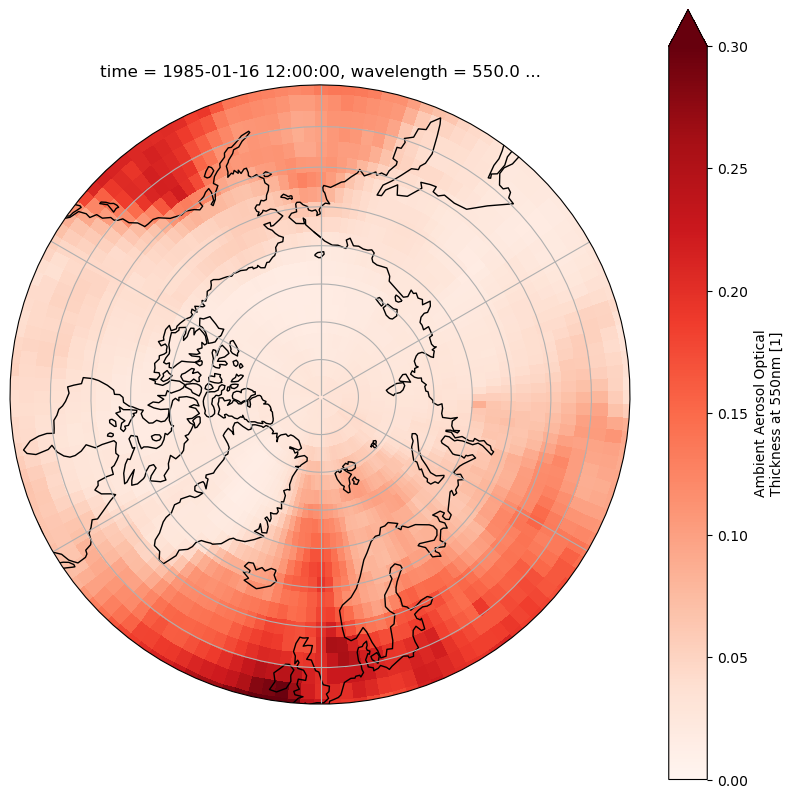

In [108]:
fig = plt.figure(1, figsize=[10,10])

# Fix extent
minval = 0
maxval = 0.3

ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
ax.coastlines()
ax.gridlines()
polarCentral_set_latlim([50,90], ax)
(ds['od550aer']
 .sel(time=cftime.DatetimeNoLeap(1985, 1, 16, 12, 0, 0, 0))
 .plot(ax=ax, vmin=minval, vmax=maxval, transform=ccrs.PlateCarree(), cmap='Reds')
)

### Get attributes (unique identifier)

In [109]:
ds.attrs['tracking_id']

'hdl:21.14100/efd7a56e-94a8-47f5-b3d8-06ae02268192\nhdl:21.14100/0c3683e7-1c3f-45d6-bbc7-414f68e7a801\nhdl:21.14100/a83a3a96-0d16-4f3e-aa88-a68f00e1ce2e\nhdl:21.14100/7a629db0-dda1-445d-a496-2e77c9c7c20a\nhdl:21.14100/388888f8-7ee4-467f-aca9-8a6e45361f55\nhdl:21.14100/7aa3797a-b0e7-427d-a209-efed00cd1724\nhdl:21.14100/33d3ae45-cb42-47e5-8c08-76df86d298a8\nhdl:21.14100/10f9c9e3-3d54-494a-b153-ea63c5b584c7\nhdl:21.14100/2a3a1f67-8890-4e89-b6de-84b2b13cf70e\nhdl:21.14100/447d4151-8161-461a-a66e-f21144baabf6\nhdl:21.14100/c1bd13af-f8b2-4b18-bd2c-34b13a4921dc\nhdl:21.14100/eee79e49-dd70-4d8f-b195-c885aca26e3a\nhdl:21.14100/7cd2e526-a94c-4004-bfe8-32832a9df6d7\nhdl:21.14100/b2421ba2-c8c9-44c0-84af-f9b09cb87759\nhdl:21.14100/f87b3cf5-e68d-40f2-a289-667b4cf7d15f\nhdl:21.14100/a6542f1a-0567-4e7a-b063-f5609f017d69\nhdl:21.14100/01e4e8d6-b84e-4d25-9f50-4a9ea5588f07'

## Regrid CMIP6 data to common NorESM2-LM grid
- Select a time range
- we use `squeeze` to remove dimension with one element only e.g. member_id='r1i1p1f1'

In [110]:
starty = '1985-01'
endy = '1986-12'

In [111]:
# Read in the output grid from NorESM
ds_out = ds.sel(time = slice(starty, endy)).squeeze() 
ds_out

<xarray.Dataset> Size: 1MB
Dimensions:         (lat: 96, bnds: 2, lon: 144, time: 24)
Coordinates:
  * lat             (lat) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
    lat_bnds        (lat, bnds) float64 2kB dask.array<chunksize=(96, 2), meta=np.ndarray>
  * lon             (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
    lon_bnds        (lon, bnds) float64 2kB dask.array<chunksize=(144, 2), meta=np.ndarray>
  * time            (time) object 192B 1985-01-16 12:00:00 ... 1986-12-16 12:...
    time_bnds       (time, bnds) object 384B dask.array<chunksize=(24, 2), meta=np.ndarray>
    wavelength      float64 8B ...
    member_id       <U8 32B 'r1i1p1f1'
    dcpp_init_year  float64 8B nan
Dimensions without coordinates: bnds
Data variables:
    od550aer        (time, lat, lon) float32 1MB dask.array<chunksize=(24, 96, 144), meta=np.ndarray>
Attributes: (12/65)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    Hybrid-restart from year 1600-01-01 of ...
    branch_time:                      0.0
    branch_time_in_child:             0.0
    branch_time_in_parent:            430335.0
    ...                               ...
    intake_esm_attrs:variable_id:     od550aer
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/NCC/NorESM2-LM/hi...
    intake_esm_attrs:version:         20190815
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NCC.NorESM2-LM.historical.AERmon.gn

In [112]:
# create dictionary for reggridded data
ds_regrid_dict = dict()
for key in dset_dict.keys():
    print(key)
    ds_in = dset_dict[key]
    ds_in = ds_in.sel(time=slice(starty, endy)).squeeze()
    regridder = xe.Regridder(ds_in, ds_out, 'bilinear')
    # Apply regridder to data
    # the entire dataset can be processed at once
    ds_in_regrid = regridder(ds_in, keep_attrs=True)
    # Save to netcdf file
    model = key.split('.')[2]
    filename = 'od550aer_AERmon.nc'
    savepath = path_to_save_data / 'CMIP6_hist' / model
    savepath.mkdir(parents=True, exist_ok=True)
    filename_out = savepath / filename 
    ds_in_regrid.to_netcdf(filename_out)
    # create dataset with all models
    ds_regrid_dict[model] = ds_in_regrid
    print(f'file written: {filename_out}')

CMIP.NCAR.CESM2-WACCM-FV2.historical.AERmon.gn
file written: ../../../../Data_processed/CMIP6_hist/CESM2-WACCM-FV2/od550aer_AERmon.nc
CMIP.NCAR.CESM2-FV2.historical.AERmon.gn
file written: ../../../../Data_processed/CMIP6_hist/CESM2-FV2/od550aer_AERmon.nc
CMIP.CCCma.CanESM5.historical.AERmon.gn
file written: ../../../../Data_processed/CMIP6_hist/CanESM5/od550aer_AERmon.nc
CMIP.MRI.MRI-ESM2-0.historical.AERmon.gn
file written: ../../../../Data_processed/CMIP6_hist/MRI-ESM2-0/od550aer_AERmon.nc
CMIP.NCAR.CESM2.historical.AERmon.gn
file written: ../../../../Data_processed/CMIP6_hist/CESM2/od550aer_AERmon.nc
CMIP.NCAR.CESM2-WACCM.historical.AERmon.gn
file written: ../../../../Data_processed/CMIP6_hist/CESM2-WACCM/od550aer_AERmon.nc
CMIP.MPI-M.MPI-ESM1-2-LR.historical.AERmon.gn
file written: ../../../../Data_processed/CMIP6_hist/MPI-ESM1-2-LR/od550aer_AERmon.nc
CMIP.HAMMOZ-Consortium.MPI-ESM-1-2-HAM.historical.AERmon.gn
file written: ../../../../Data_processed/CMIP6_hist/MPI-ESM-1-2-HAM/od5

## Concatenate all models

In [116]:
import cftime

In [115]:
for k in ds_regrid_dict.keys():
    _ds = ds_regrid_dict[k]

    _ds= _ds.resample(time='1M').mean('time')
    # change calendar 
    units = 'days since 1900-01-01'
    _t = _ds.time
    _ds['time'] = cftime.date2num(_t.values, 'days since 1900-01-01')
    _ds['time'].attrs['units'] = units
    _ds = xr.decode_cf(_ds)
    ds_regrid_dict[k] = _ds

In [117]:
_ds = list(ds_regrid_dict.values())
_coord = list(ds_regrid_dict.keys())
ds_out_regrid = xr.concat(objs=_ds, dim=_coord, coords="all").rename({'concat_dim':'model'})
ds_out_regrid

<xarray.Dataset> Size: 29MB
Dimensions:         (lat: 96, lon: 144, time: 48, model: 11)
Coordinates:
  * lat             (lat) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon             (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * time            (time) datetime64[ns] 384B 1985-01-10 ... 1986-12-31
    member_id       (model) <U8 352B 'r1i1p1f1' 'r1i1p1f1' ... 'r1i1p1f1'
    dcpp_init_year  (model) float64 88B nan nan nan nan nan ... nan nan nan nan
    wavelength      (model) float64 88B 550.0 550.0 550.0 ... 550.0 550.0 550.0
  * model           (model) object 88B 'CESM2-WACCM-FV2' ... 'MPI-ESM1-2-HR'
Data variables:
    od550aer        (model, time, lat, lon) float32 29MB dask.array<chunksize=(1, 48, 64, 128), meta=np.ndarray>
Attributes: (12/62)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             674885.0
    branch_time_in_parent:            10950.0
    case_id:                          1562
    ...                               ...
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM-...
    intake_esm_attrs:version:         20191120
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NCAR.CESM2-WACCM-FV2.historical.AE...
    regrid_method:                    bilinear

## Compute seasonal mean of all regridded models

In [118]:
ds_seas = ds_out_regrid.mean('model', keep_attrs=True, skipna = True).groupby('time.season').mean('time', keep_attrs=True, skipna = True)
ds_seas

<xarray.Dataset> Size: 223kB
Dimensions:   (season: 4, lat: 96, lon: 144)
Coordinates:
  * lat       (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon       (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * season    (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    od550aer  (season, lat, lon) float32 221kB dask.array<chunksize=(4, 64, 128), meta=np.ndarray>
Attributes: (12/62)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             674885.0
    branch_time_in_parent:            10950.0
    case_id:                          1562
    ...                               ...
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM-...
    intake_esm_attrs:version:         20191120
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NCAR.CESM2-WACCM-FV2.historical.AE...
    regrid_method:                    bilinear

In [120]:
ds_seas['od550aer'].min().compute(), ds_seas['od550aer'].max().compute()

(<xarray.DataArray 'od550aer' ()> Size: 4B
 array(0.00279297, dtype=float32),
 <xarray.DataArray 'od550aer' ()> Size: 4B
 array(1.4087572, dtype=float32))

## Save seasonal mean in a new netCDF file 

In [121]:
path_to_save_data

PosixPath('../../../../Data_processed')

In [122]:
filename = path_to_save_data / 'CMIP6_hist'/'od550aer_seasonal.nc'
ds_seas.to_netcdf(filename)

## Visualize final results (seasonal mean for all models)

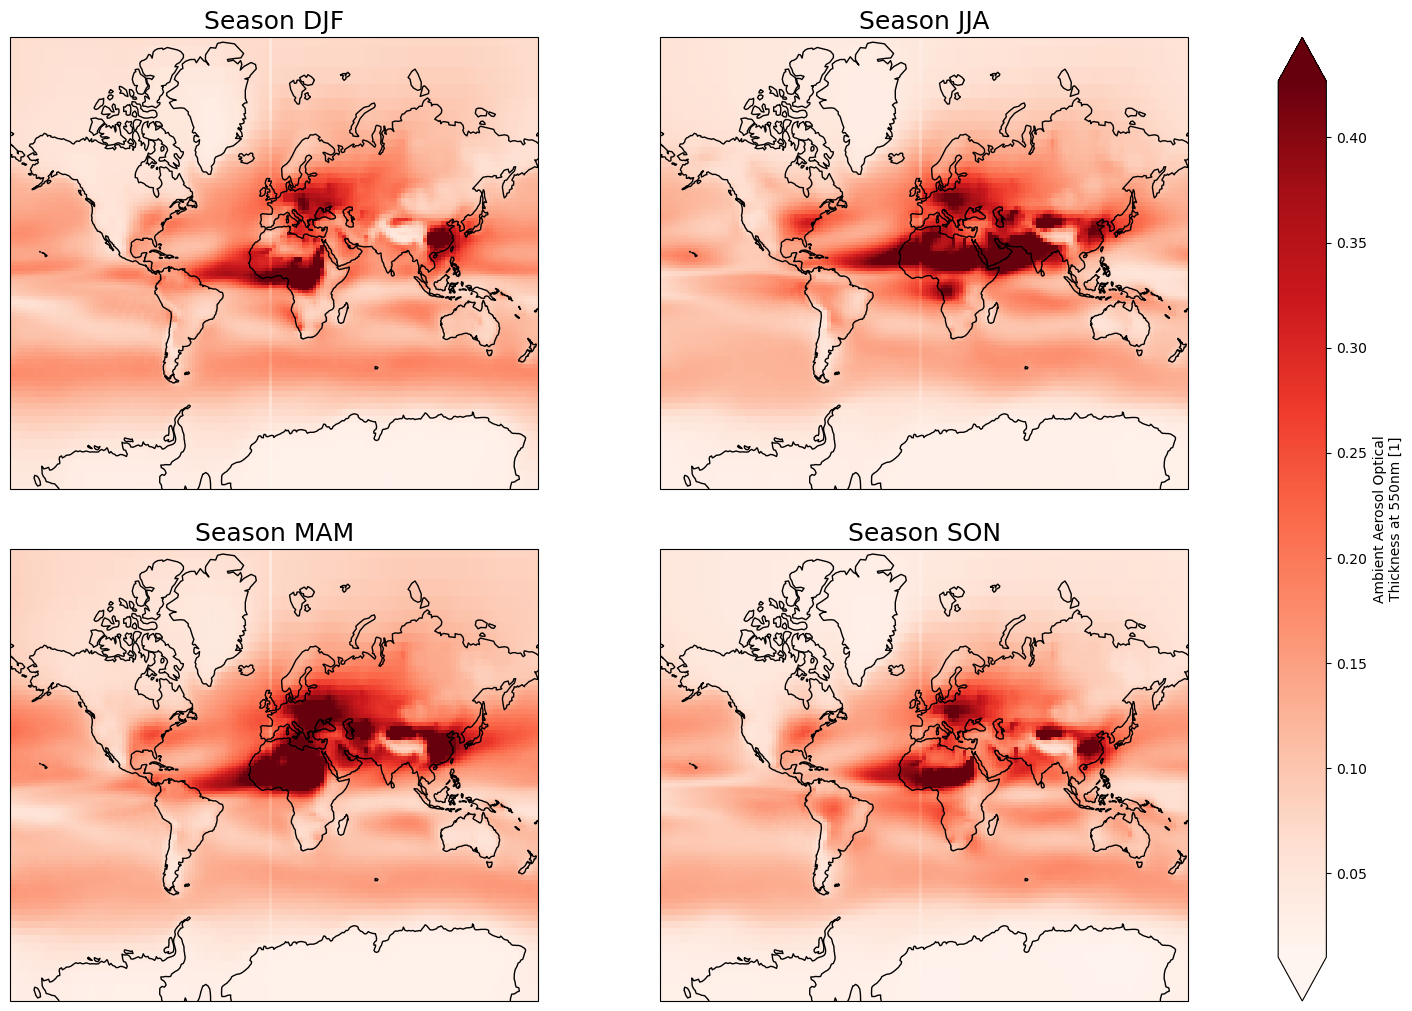

In [124]:
import matplotlib
proj_plot = ccrs.Mercator()

p = ds_seas['od550aer'].plot(x='lon', y='lat', 
                             transform=ccrs.PlateCarree(),
                             aspect=ds_seas.dims["lon"] / ds_seas.dims["lat"],  # for a sensible figsize
                             subplot_kws={"projection": proj_plot},
                             col='season', col_wrap=2, robust=True, 
                             cmap='Reds')
# We have to set the map's options on all four axes
for ax,i in zip(p.axes.flat, ds_seas.season.values):
    ax.coastlines()
    ax.set_title('Season '+i, fontsize=18)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('od550aer_seasonal_mean.png', dpi=100)